In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [3]:

db = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='Wildcard@097',
    database='ecommerce'
)
cur = db.cursor()

In [5]:
query = """ 
select 
      distinct customer_city 
from 
      customers 
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [7]:
query = """ 
SELECT Count(order_id)
FROM   orders
WHERE  Year(order_purchase_timestamp) = 2017 
"""

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 90202)

# Find the total sales per category.

In [8]:
query = """ 
SELECT Upper(products.product_category)      AS category,
       Round(Sum(payments.payment_value), 2) AS sales
FROM   products
       JOIN order_items
         ON products.product_id = order_items.product_id
       JOIN payments
         ON payments.order_id = order_items.order_id
GROUP  BY category 
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,FASHION BAGS AND ACCESSORIES,1745266.24
4,BED TABLE BATH,13700429.37
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


# Calculate the percentage of orders that were paid in installments.

In [9]:
query = """ 
SELECT ( ( Sum(CASE
                 WHEN payment_installments >= 1 THEN 1
                 ELSE 0
               END) ) / Count(*) ) * 100
FROM   payments 
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state. 

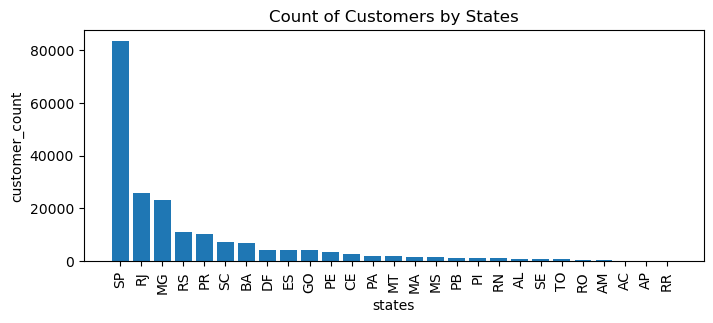

In [10]:
query = """ 
SELECT customer_state,
       Count(customer_id)
FROM   customers
GROUP  BY customer_state 
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018.

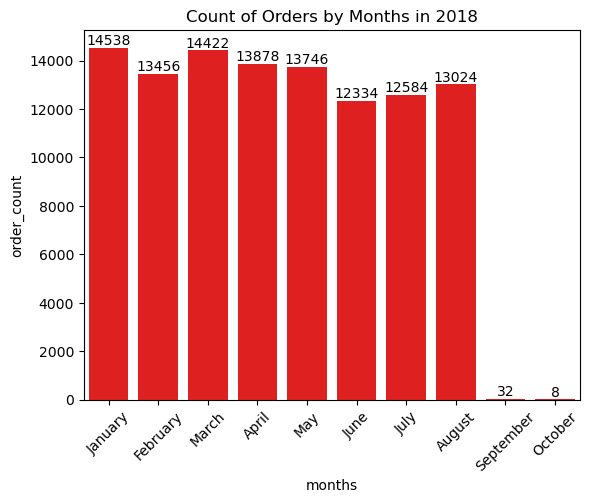

In [12]:
query = """ 
SELECT Monthname(order_purchase_timestamp) months,
       Count(order_id)                     order_count
FROM   orders
WHERE  Year(order_purchase_timestamp) = 2018
GROUP  BY months 
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [13]:
query = """
WITH count_per_order
     AS (SELECT orders.order_id,
                orders.customer_id,
                Count(order_items.order_id) AS oc
         FROM   orders
                JOIN order_items
                  ON orders.order_id = order_items.order_id
         GROUP  BY orders.order_id,
                   orders.customer_id)
SELECT customers.customer_city,
       Round(Avg(count_per_order.oc), 2) average_orders
FROM   customers
       JOIN count_per_order
         ON customers.customer_id = count_per_order.customer_id
GROUP  BY customers.customer_city
ORDER  BY average_orders DESC 
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


# Calculate the percentage of total revenue contributed by each product category.

In [14]:
query = """
SELECT Upper(products.product_category) category,
       Round(( Sum(payments.payment_value) / (SELECT Sum(payment_value)
                                              FROM   payments) ) * 100, 2)
                                        sales_percentage
FROM   products
       JOIN order_items
         ON products.product_id = order_items.product_id
       JOIN payments
         ON payments.order_id = order_items.order_id
GROUP  BY category
ORDER  BY sales_percentage DESC 
"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


# Identify the correlation between product price and the number of times a product has been purchased.

In [17]:
query = """
SELECT products.product_category,
       Count(order_items.product_id),
       Round(Avg(order_items.price), 2)
FROM   products
       JOIN order_items
         ON products.product_id = order_items.product_id
GROUP  BY products.product_category 
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

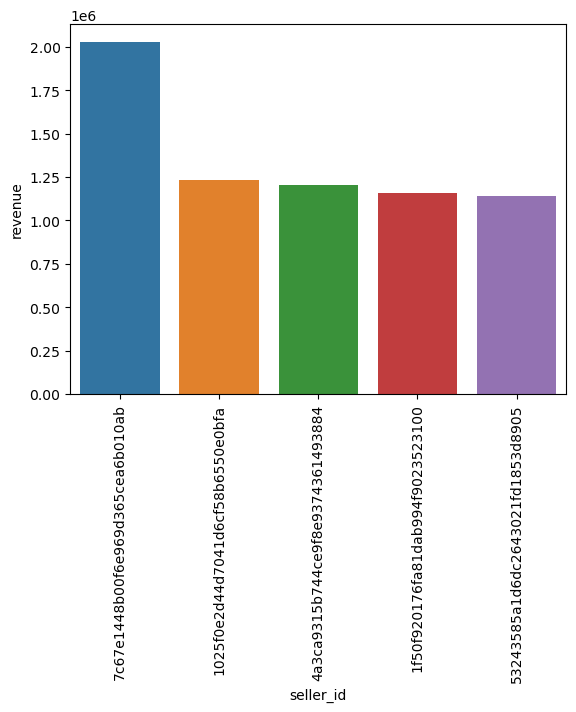

In [18]:
query = """ 
SELECT *,
       Dense_rank()
         OVER(
           ORDER BY revenue DESC) AS rn
FROM   (SELECT order_items.seller_id,
               Sum(payments.payment_value) revenue
        FROM   order_items
               JOIN payments
                 ON order_items.order_id = payments.order_id
        GROUP  BY order_items.seller_id) AS a 
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [20]:
query = """
SELECT customer_id,
       order_purchase_timestamp,
       payment,
       Avg(payment)
         over(
           PARTITION BY customer_id
           ORDER BY order_purchase_timestamp ROWS BETWEEN 2 preceding AND
         CURRENT ROW)
       AS mov_avg
FROM   (SELECT orders.customer_id,
               orders.order_purchase_timestamp,
               payments.payment_value AS payment
        FROM   payments
               join orders
                 ON payments.order_id = orders.order_id) AS a 
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_time", "purchase", "moving-average"])
df



,customer_id,order_time,purchase,moving-average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


#  Calculate the cumulative sales per month for each year.

In [29]:
query = """
SELECT years,
       months,
       payment,
       Sum(payment)
         OVER(
           ORDER BY years, months) cumulative_sales
FROM   (SELECT Year(orders.order_purchase_timestamp)  AS years,
               Month(orders.order_purchase_timestamp) AS months,
               Round(Sum(payments.payment_value), 2)  AS payment
        FROM   orders
               JOIN payments
                 ON orders.order_id = payments.order_id
        GROUP  BY years,
                  months
        ORDER  BY years,
                  months) AS a 
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df


,0,1,2,3
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# Calculate the year-over-year growth rate of total sales.

In [30]:
query = """
WITH a
     AS (SELECT Year(orders.order_purchase_timestamp) AS years,
                Round(Sum(payments.payment_value), 2) AS payment
         FROM   orders
                JOIN payments
                  ON orders.order_id = payments.order_id
         GROUP  BY years
         ORDER  BY years)
SELECT years,
       ( ( payment - Lag(payment, 1)
                       OVER(
                         ORDER BY years) ) / Lag(payment, 1)
                                               OVER(
                                                 ORDER BY years) ) * 100
FROM   a 
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [31]:
query = """
WITH a
     AS (SELECT customers.customer_id,
                Min(orders.order_purchase_timestamp) first_order
         FROM   customers
                join orders
                  ON customers.customer_id = orders.customer_id
         GROUP  BY customers.customer_id),
     b
     AS (SELECT a.customer_id,
                Count(DISTINCT orders.order_purchase_timestamp) next_order
         FROM   a
                join orders
                  ON orders.customer_id = a.customer_id
                     AND orders.order_purchase_timestamp > first_order
                     AND orders.order_purchase_timestamp < Date_add(first_order,
                                                           interval 6 month)
         GROUP  BY a.customer_id)
SELECT 100 * ( Count(DISTINCT a.customer_id) / Count(DISTINCT b.customer_id) )
FROM   a
       left join b
              ON a.customer_id = b.customer_id ;
"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# As there are no customers who have bought products within 6 months, The value is null.

# Identify the top 3 customers who spent the most money in each year.

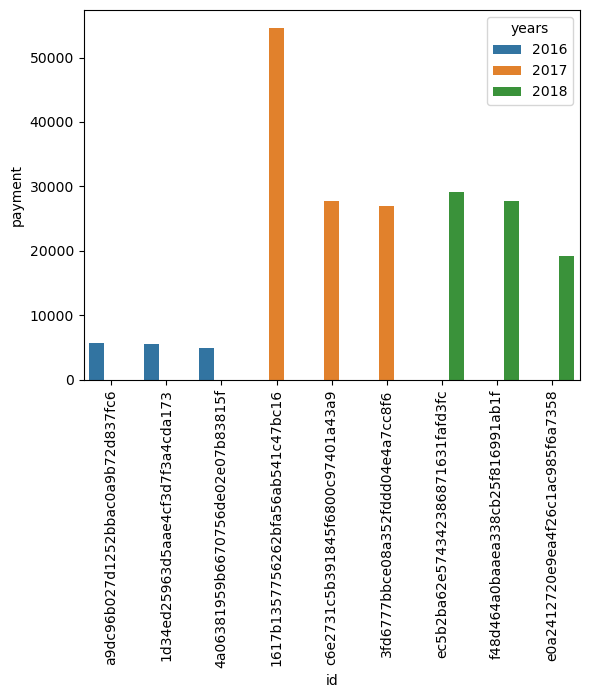

In [33]:
query = """
SELECT years,
       customer_id,
       payment,
       d_rank
FROM   (SELECT Year(orders.order_purchase_timestamp)          years,
               orders.customer_id,
               Sum(payments.payment_value)                    payment,
               Dense_rank()
                 OVER(
                   partition BY Year(orders.order_purchase_timestamp)
                   ORDER BY Sum(payments.payment_value) DESC) d_rank
        FROM   orders
               JOIN payments
                 ON payments.order_id = orders.order_id
        GROUP  BY Year(orders.order_purchase_timestamp),
                  orders.customer_id) AS a
WHERE  d_rank <= 3; 
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])

# Convert the 'years' column to string
df['years'] = df['years'].astype(str)

sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()